<a href="https://colab.research.google.com/github/timmmariya/Empirical-Law-Studies/blob/main/2_%D0%9F%D0%BE%D0%B8%D1%81%D0%BA_%D1%84%D0%B8%D0%BA%D1%81%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%BD%D1%8B%D1%85_%D0%BA%D0%BE%D1%8D%D1%84%D1%84%D0%B8%D1%86%D0%B8%D0%B5%D0%BD%D1%82%D0%BE%D0%B2_%D0%B4%D0%BB%D1%8F_%D1%81%D1%83%D0%BC%D0%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Представленный Colab Notebook является частью серии наработок по исследованиям в области практической оценки судопроизводства методами численного анализа, проводимых [НУЛ анализа данных правоприменения НИУ ВШЭ](https://adp.hse.ru/). 

Контактная информация рабочей группы: gkrasnozhenov@hse.ru (Григорий Григорьевич Красноженов, ЗавЛаб НУЛ АДП), timmariya541@gmail.com (Мария Тимонина, стажер, ответственный за текущую задачу)

Материалом для анализа служат **данные системы арбитражных судов РФ**.

---

### Стандартный пролог подключения библиотек и загрузки базы данных в pandas DataFrame:

In [ ]:
import numpy as np          # библиотека для матриц и математики
import pandas as pd         # библиотека для работы с табличками
from scipy import stats     # модуль для работы со статистикой
from matplotlib import colors

#библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot') # стиль графиков
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/НУЛ АДП Материалы Марии Тимониной/_data/ArbitrageCleanedforSums.csv'
df_wn = pd.read_csv(path, sep=',')

In [ ]:
df_wn =  df_wn[(df_wn['Сумма Иска'] > 0) & (df_wn['Сумма Взысканий'] > 0)]
df_wn.head()

,Номер Дела,Суд,Вид Спора,Категория Спора,Сумма Иска,Сумма Взысканий,Начало,Продолжительность,Конец
0,А01-121/2014,АС Республики Адыгея,Г,О неисполнении или ненадлежащем исполнении обя...,34484.90,36484.90,2014-01-31,670,2015-12-02
1,А01-122/2014,АС СКО,Г,Иные экономические споры,132000.00,176979.00,2014-01-31,419,2015-03-26
3,А02-142/2014,АС Республики Алтай,Г,О возмещении вреда,4612.55,4612.55,2014-01-31,82,2014-04-23
4,А02-144/2014,АС Республики Алтай,Г,О неисполнении или ненадлежащем исполнении обя...,17745.20,2000.00,2014-01-31,57,2014-03-29
6,А03-1509/2014,АС Алтайского края,Г,О неисполнении или ненадлежащем исполнении обя...,107657.00,107657.00,2014-01-31,176,2014-07-26


## **Визуализация и Постановка задачи**

Ведется рассмотрение соотношения размеров Сумм Иска и Взыскания с целью определения способа их взаимной зависимости. При первом изображении на графике всех дел, в которых оба показателя положительны выявлены соотношения, которым соответствует особенно большое количтсво дел. В настоящем блоке будет исследован вопрос их алгоритмического обнаружения и исключения из случайной выборки.

---


In [ ]:
def plot_props_sums(ax, upper_bound, df) :
    df_curr = df[(df['Сумма Иска']< upper_bound )  & (df['Сумма Взысканий'] < upper_bound )]
    ax.set_xlim(0, upper_bound)
    ax.set_ylim(0, upper_bound)

    ax.plot(df_curr['Сумма Иска'], df_curr['Сумма Взысканий'], 'k.')
    ax.set_xlabel('Сумма Иска')
    ax.set_ylabel('Сумма Взысканий')
    return df_curr.shape[0]

Множество точек на первом графике соответствует 1777486 записям, на втором  1777075 , на третьем 1771871


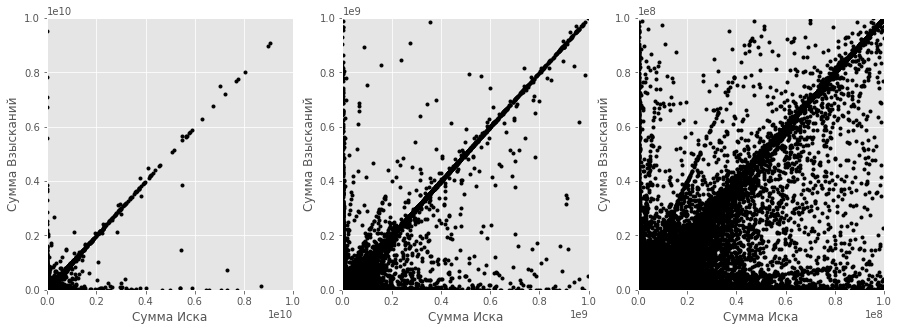

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 5))
print("Множество точек на первом графике соответствует", plot_props_sums(ax1, 10**10, df_wn), 
      "записям, на втором ", plot_props_sums(ax2, 10**9, df_wn),
      ", на третьем", plot_props_sums(ax3, 10**8, df_wn))

#fig.suptitle("Суммы, как бы это обозвать...", fontsize=16);


Существование линии устойчивости с  коэффициентом 1 (Сумма Иска совпадает с  Суммой Взыскания) ожидаемо - на нее попадают все дела с удовлетворенным полностью иском. Но есть и другие прямые, сформированные реальными данными, которые показывают стабильные коэффициенты соотношения иска и взыскания. Содержательным вопросом для дальнейших исследований будет поиск нормативных актов, закрепляющих применение этих коэффициентов в судебной практике. Так, в первом приближении были подобраны коэффициенты 1 : 2, 1 : 10 и 10 : 1 (на рисунке 5 справа).

In [ ]:
(df_wn['Сумма Иска'] > 10**10 ).sum(), (df_wn['Сумма Взысканий'] > 10**10 ).sum()

(19, 36)

Для наглядности ни на одном из графиков также не отображены точки, соответствующие спорам, в которых любая из двух сумм превышает **10 млрд. рублей.** Таких дел порядка 50, а именно 19 по сумме Иска и 36 по сумме Взыскания. Есть основания предполагать, что порядок сумм, указанных в этих записях, слишком велик и не соответствует реалиам российского судопроизводства, поэтому можно подозревать наличие ошибок при занесении в базу КАД.

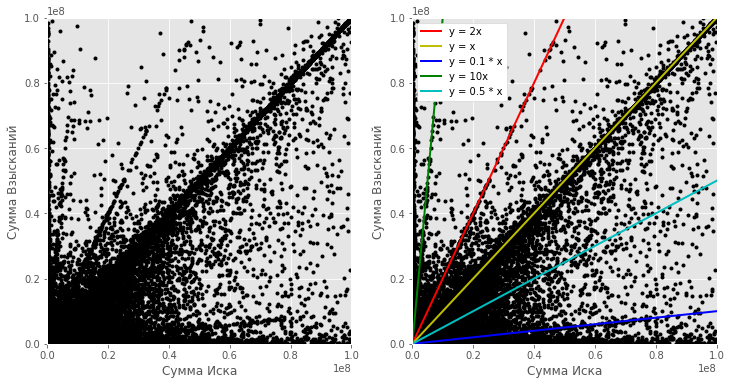

In [ ]:
#lambda-функция прямой
lineFunc = lambda x, w0, w1: w0 + w1 * x

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
plot_props_sums(ax1, 10**8, df_wn)
plot_props_sums(ax2, 10**8, df_wn)

x = np.linspace(0, 10**8, 1000)
line1, = ax2.plot(x, lineFunc(x, 0, 2), 'r', linewidth=2.0)
line1.set_label('y = 2x')
line2, = ax2.plot(x, lineFunc(x, 0, 1), 'y', linewidth=2.0)
line2.set_label('y = x')
line3, = ax2.plot(x, lineFunc(x, 0, 1/10), 'b', linewidth=2.0)
line3.set_label('y = 0.1 * x')
line4, = ax2.plot(x, lineFunc(x, 0, 10), 'g', linewidth=2.0)
line4.set_label('y = 10x')
line5, = ax2.plot(x, lineFunc(x, 0, 1/2), 'c', linewidth=2.0)
line5.set_label('y = 0.5 * x')
ax2.legend(facecolor='white', framealpha=1)

https://habr.com/ru/post/514818/ Очень наглядный пост, разобраться

#**Разбиение на углы**

Прямая, проходящая через начало координат и заданную на окружности точку $W$ описывается уравнением: $$\cos(\angle W) \cdot y - \sin(\angle W) \cdot x = 0$$

In [ ]:
from math import sin, cos, pi, atan, tan
pd.options.mode.chained_assignment = None  # default='warn'

**`Sin(x)`** - это возрастающая функция на отрезке от нуля до пи пополам, поэтому можно для каждой точки определить синус угла наклона прямой, соединяющей ее с (0, 0), к оси абсцисс, в текущих обозначениях - оси Сумм Иска, и заметить, что точка лежит в границах угла, если соответствующий ей синус заключен между синусами углов для его сторон.

In [ ]:
df_ang = df_wn[['Сумма Иска', 'Сумма Взысканий']]

На текущем этапе работа ведется не по всем данными из картотеки, а только с суммами, фигурирующими в делах. Создадим отдельный dataFrame **`df_ang`** для простоты структуры.

$\sin(\angle W)$ - это отношение длины проекции отрезка, соединяющего $W$ c началом координат на плоскости, к длине этого отрезка. Длина высчитывается как корень из суммы квадратов координат вектора в новом столбце **`df_ang['len']`**, далее с использованием этого значения вычисляется синус угла в **`df_ang['sin']`**.

In [ ]:
df_ang['len'] = np.sqrt(df_ang['Сумма Взысканий']**2 + df_ang['Сумма Иска']**2)
df_ang['sin'] = df_ang['Сумма Взысканий'] / df_ang['len']
df_ang['cos'] = df_ang['Сумма Иска'] / df_ang['len']
df_ang.head()


,Сумма Иска,Сумма Взысканий,len,sin,cos
0,34484.90,36484.90,50203.149862,0.726745,0.686907
1,132000.00,176979.00,220783.981396,0.801593,0.597869
3,4612.55,4612.55,6523.130767,0.707107,0.707107
4,17745.20,2000.00,17857.550869,0.111997,0.993708
6,107657.00,107657.00,152249.989484,0.707107,0.707107


Следует проверить вычисления на корректность, чтобы убедиться в том, что дальнейшая сортировка точек по величине угла отбирает точки из заданного угла. С этой целью визуализируем отображение каждой точки из промежутка $\left[ \frac{\pi}{4} + \frac{\pi}{6}, \frac{\pi}{4} \right]$ на единичную тригонометрическую окружность $(W_X, W_Y) \rightarrow (cos(W), sin(W))$.

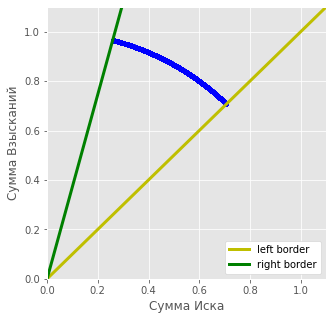

In [ ]:
left = pi / 4
right = pi / 4 + pi/6

df_curr = df_ang[ (df_ang.sin >= sin(left)) & (df_ang.sin < sin(right))]

upper_bound = 1.1
fig, ax = plt.subplots(ncols=1, figsize=(5, 5))
ax.set_xlim(0, upper_bound)
ax.set_ylim(0, upper_bound)

ax.plot(df_curr['cos'], df_curr['sin'], 'b.')
ax.set_xlabel('Сумма Иска')
ax.set_ylabel('Сумма Взысканий')

x = np.linspace(0, upper_bound, 100)
line1, = ax.plot(x, lineFunc(x, 0, sin(left) / cos(left)), 'y', linewidth=3.0)
line1.set_label('left border')
line2, = ax.plot(x, lineFunc(x, 0, sin(right) / cos(right)), 'g', linewidth=3.0)
line2.set_label('right border')

ax.legend(facecolor='white', framealpha=1)

Угол отобран правильно.

# **Подходы  к поиску потенциально устойчивых коэффициентов**

## I. Минимизация квадратической ошибки

### Описание идеи

*Задачу восстановления регрессии* принято решать путем минимизации **квадратической функции средней относительной ошибки** $$\sqrt{\frac{1}{n} \sum_{i = 1}^n (\frac{y_i - y_{linear}}{y_i})^2 }= \sqrt{\frac{1}{n} \sum_{i = 1}^n (1 - \frac{y_{linear}}{y_i})^2},$$
где $y_{linear} = w_0 + w_1 \cdot x$,  $w_1 = \tan{\angle W}$ 

Через каждое заключенное между двумя лучами (сторонами угла) облако точек в пространстве признаков "Сумма Иска" и "Сумма Взысканий" проводится прямая из начала координат так, чтобы минимизировать этот функционал. Такая прямая называется **наилучшее линейное приближение**.

In [ ]:
def classic_mrse(w0, w1, data):
    error = ((data['Сумма Взысканий'] - (w0 + w1 * data['Сумма Иска'])) / data['Сумма Взысканий']) ** 2
    return np.sqrt(error.sum() / data.shape[0])

Квадратическая функция ошибки **выпуклая**, для задачи ее минимизации существуют различные оптимизационные методы. 

В рассматриваемом множестве прямых, проходящих через начало координат (производится поиск значимых коэффициентов соотношения), свободный член $w_0$ зафиксирован и **равен нулю**, поэтому можем считать, что функция зависит от единственного параметра. Воспользуемся встроенной функцией **`minimize_scalar`** пакета **`scipy.optimize`**

Ее реализация основывается на широко применяемом и эффективном **методе Брента**, использующем алгоритм обратной параболической интерполяции.

In [ ]:
import scipy.optimize as opt

error_wrap = lambda w1: classic_mrse(0, w1, df_wn)
wmin = opt.minimize_scalar(error_wrap)
wmin

     fun: 0.9999991455764782
    nfev: 23
     nit: 19
 success: True
       x: 2.739505553115602e-09

Искомое значение углового коэффициента прямой с наименьшей ошибкой возвращается в поле `wmin.x`. С учетом вида функции ошибок - параболы с ветвями вверх - дополнительная проверка флага успешности завершения градиентного спуска не требуется, он всегда будет равен `True`.

### **Релизация подхода MRSE**

Теперь можно объединить алгоритмы разбиения и наилучшего линейного приближения облака точек внутри каждого из углов применительно к изучаемому датасету.


Приведенная функция **`calculate_linear_approximations(num_parts, visualise=1)`** делит все пространство на **num_parts** углов, определяет (и изображает на графике, заупуская функцию **`draw_lin_approx(upper_bound, df, coeffs, mrse)`** если параметр visualise не задан как ноль) наилучшее линейное приближение внутри каждого угла. Возвращаются массивы **`coeffs, mrse`**, хранящие значения соотв. прямой точки на окружности и среднюю квадратическую относительную ошибку.



**`step`** - длина соответствующей одному углу части единичной тригонометрической окружности, 

**`left`** и **`right`** - числа, задающие граничные точки очередного угла на круге

In [ ]:
def draw_lin_approx(fig, ax, upper_bound, df, coeffs, mrse, fmt='m', leg='None') :
    upper_bound = 10**8
    num = len(coeffs)

    plot_props_sums(ax, upper_bound, df)

    x = np.linspace(0, 10 * upper_bound, 1000)
    lines = [0 for i in range(num)]
    #borders = [0 for i in range(num)]

    
    for k in range(num) :
        lines[k], = ax.plot(cos(coeffs[k]) * x, sin(coeffs[k]) * x, fmt,  linewidth=3.0)
        if ((leg == 'std_mrse') |  (leg == 'new_mrse')): lines[k].set_label("{:.5f}".format(mrse[k]))
        if leg == 'coef' : lines[k].set_label("{:.4f}".format(tan(coeffs[k])))
        #step = 1 / num_parts * (pi / 2)
        #left = k * step
        #borders[k], = ax.plot(x, lineFunc(x, 0, sin(left) / cos(left)), 'c')

    if leg != 'None': ax.legend(facecolor='white', framealpha=1);

In [ ]:
def calc_linear_approximations_mrse(num_parts, df_ang=df_ang, visualise=1, pic_size=9) :
  coeffs = [0 for i in range(num_parts)]
  mrse = [0 for i in range(num_parts)]

  step = 1 / num_parts * (pi / 2)
  for k in range(num_parts) :
      # задаем  точки, соотв границам угла, на тригонометрической окружности от 0 до пи пополам
      left = k * step
      right = (k + 1) * step
      # воспользуемся монотонностью sin(x)
      df_curr = df_ang[ (df_ang.sin >= sin(left)) & (df_ang.sin < sin(right))]

      error_wrap = lambda w1: classic_mrse(0, w1, df_curr)
      wmin = opt.minimize_scalar(error_wrap)
      # wmin.x - тангенс искомого угла, точки на единичной окружности
      coeffs[k] = atan(wmin.x)
      mrse[k] = wmin.fun

  if (visualise) :
      fig, ax = plt.subplots(ncols=1, figsize=(pic_size, pic_size))
      draw_lin_approx(fig, ax, 10**8, df_wn, coeffs, mrse)

  return coeffs, mrse

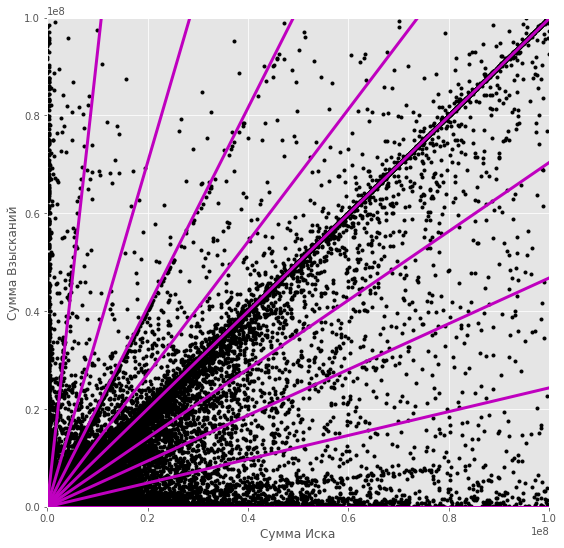

In [ ]:
coeffs, mrse = calc_linear_approximations_mrse(9)

Как определить среди всех найденных прямых те, которые задают кандидата на устойчивый коэффициент, а не только минимизируют функцию MRSE для заданного облака?

**План:** разбить все пространство точек на значительно большее число углов, "малых окретностей" прямых и отбирать как кандидатов те из них, ошибка для которых достаточно мала.

### Оценка качества приближения в подходе I.

**Какую величину ошибки следует считать достаточно маленькой, чтобы коэффициент можно было рассматривать как устойчивый?**


В блоке кода ниже производится разбивка множества точек на `quant_parts=101` углов.

Найденные прямые - линейные приближения - ранжируются по возрастанию средней квадратической ошибки, на изображение выводятся лучшие 10 результатов.

In [ ]:
quant_parts = 181
cs, mrse = calc_linear_approximations_mrse(quant_parts, visualise=0)

df_prec = pd.DataFrame(cs, columns=['Points'])
df_prec['MRSE'] = mrse
df_prec['Angle Num'] = df_prec.index
df_prec.sort_values(by='MRSE', inplace=True)

df_prec_best = df_prec[:20].sort_values(by='Points')

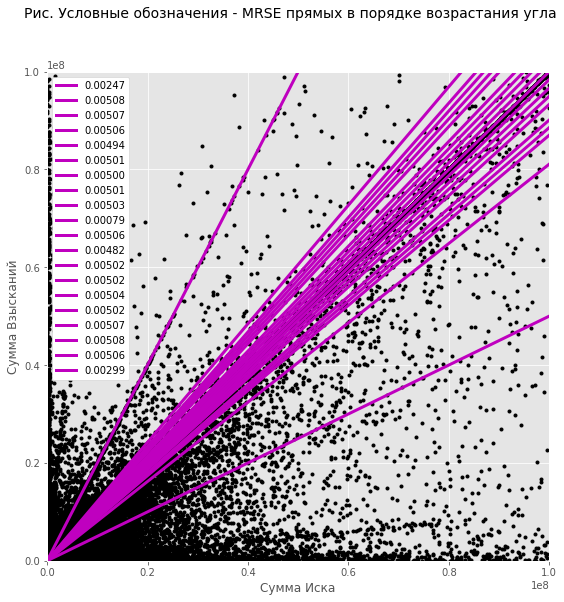

In [ ]:
pic_size=9
fig, ax = plt.subplots(ncols=1, figsize=(pic_size, pic_size))
draw_lin_approx(fig, ax, upper_bound=10**8,
                df=df_wn, 
                coeffs=df_prec_best['Points'].to_list(), 
                mrse=df_prec_best['MRSE'].to_list(),
                leg='std_mrse')
fig.suptitle('Рис. Условные обозначения - MRSE прямых в порядке возрастания угла', fontsize=14);

**Микровывод:** Средняя квадратическая ошибка чувствительна к степени наклона рассматриваемого угла, ограничивающего множество точек, и приоритизирует те дела, для которых сумма иска больше, "более горизонтальные" облака. Хотя на графике центральные всеже выбираются алгоритмом первыми. Можно выдвинуть предположение о том, что так происходит потому что дел около прямой (Иск == Взыскание) в разы больше и сотни тысяч точек лежат очень близко к определяемой линии, искажая сравнение. Иллюстрацию проблемы MRSE можно увидеть в первой ячейке раздела II.3) Уточненная функция потерь.

## Пробные улучшения

### **1) Степень концентрации точек**

Усреднение ошибки не позволяет учесть количественное превосходство по количеству дел, точки которых располагаются в окрестности прямой, для одного коэффициента наклона прямой перед другим. 

Предлагается выбирать значимые для рассмотрения углы как те, в которые попадает наибольшее количество точек, и далее уже в рамках одного угла искать линейное приближение, проанализировав величины ошибок отдельно. Также следует рассмотреть и другие функции потерь для минимизации по описанным в пункте выше соображениям.

Добавим в качестве третьего возвращаемого в функции, вычисляющей приближения списка массив размера выборки для каждого угла - `df_curr[k].size[0]` 

In [ ]:
def calc_linapprox_on_size(num_parts, df_ang=df_ang, visualise=True, pic_size=9) :
  coeffs = [0 for i in range(num_parts)]
  mrse = [0 for i in range(num_parts)]
  dots = [0 for i in range(num_parts)]

  step = 1 / num_parts * (pi / 2)
  for k in range(num_parts) :
    left = k * step
    right = (k + 1) * step
    df_curr = df_ang[ (df_ang.sin >= sin(left)) & (df_ang.sin < sin(right))]
    dots[k] = df_curr.shape[0]
    if dots[k] == 0:
        mrse[k] = 100
    else: 
        error_wrap = lambda w1: classic_mrse(0, w1, df_curr)
        wmin = opt.minimize_scalar(error_wrap)
        # wmin.x - тангенс искомого угла, точки на единичной окружности
        coeffs[k] = atan(wmin.x)
        mrse[k] = wmin.fun

  if (visualise) :
      fig, ax = plt.subplots(ncols=1, figsize=(pic_size, pic_size))
      draw_lin_approx(fig, ax, 10**8, df_wn, coeffs, mrse)

  return coeffs, mrse, dots

В блоке кода ниже производится разбиение первой четверти плоскости на 181 часть, примерно по 0,5 градуса в каждой. Для всех углов определяется лучшее линейное приближение таким же образом, как и в первом подходе. 

Далее ***на первом графике*** отображаются прямые соответствующие 20 углам, в которых заключено наибольшее число дел. ***На второй визуализации*** производится попытка  учесть размеры выборок и одновременно исключить приближения с большой ошибкой MRSE. Выбираются 45 самых крупных выборок (примерно четверть), из них отображаются так же 20 с наименьшей средней квадратической относительной ошибкой.

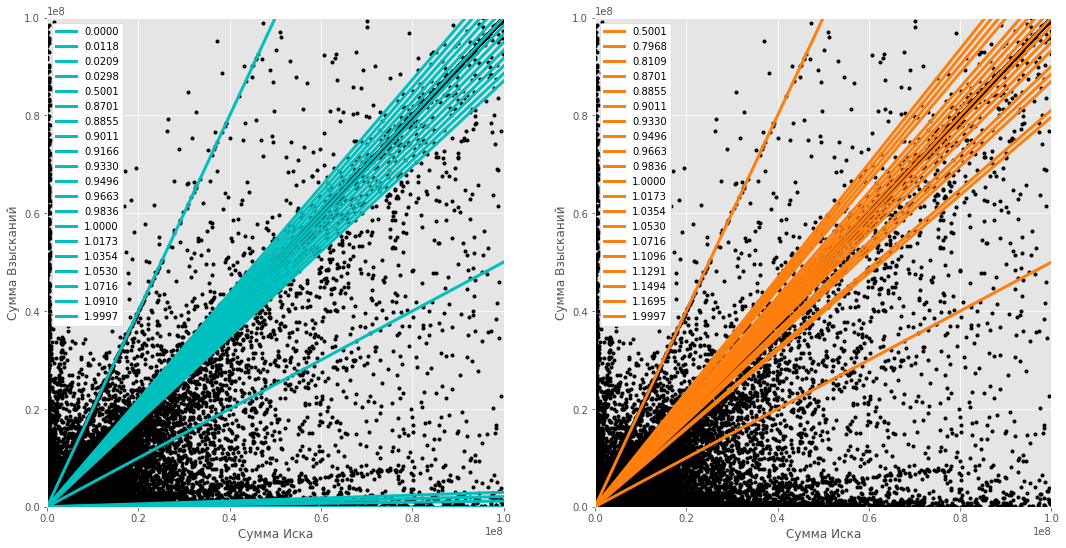

In [ ]:
quant_parts = 181
cs, mrse, sz = calc_linapprox_on_size(quant_parts, visualise=0)

df_szl = pd.DataFrame(cs, columns=['Points'])
df_szl['MRSE'] = mrse
df_szl['Size'] = sz
df_szl['Num'] = df_szl.index
df_szl.sort_values(by='Size', ascending=False, inplace=True)

pic_size=9
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(2 * pic_size, pic_size))

df_szl_best = df_szl[:20].sort_values(by='Points')
draw_lin_approx(fig, ax1, upper_bound=10**8,
                df=df_wn, 
                coeffs=df_szl_best['Points'].to_list(), 
                mrse=df_szl_best['MRSE'].to_list(), 
                fmt='c', 
                leg='coef')

df_szl_best_minmrse = df_szl[:45].sort_values(by='MRSE')[:20].sort_values(by='Points')
draw_lin_approx(fig, ax2, upper_bound=10**8,
                df=df_wn, 
                coeffs=df_szl_best_minmrse['Points'].to_list(), 
                mrse=df_szl_best['MRSE'].to_list(), 
                fmt='tab:orange', 
                leg='coef')


Как уже было замечено ранее, сравнение MRSE для разных углов выделяет углы с тангенсом наклона близким к 1 как более значимые, поэтому выделенные на первом графике прямые с околонулевым тангенсом ожидаемо не попадают на второй график. При этом в области углов, коэффициент наклона прямых в которых составляет порядка 1, заметны уточнения в работе модели. 

### **2) Рассмотрение крайних областей отдельно от центра (учет специфики)**

In [ ]:
df_more_after = df_ang[(df_ang.sin >= sin(pi / 4 + pi/16))]
df_more_before = df_ang[(df_ang.sin < sin(pi / 4 - pi/16))]

Можно предположить из вида графика, что устойчивые соотношения, удаленные от 1 в ту или иную сторону, также присутвуют, но из-за диспропорции в количестве и приоритезации центральных значений текущей используемой функцией потерь они мало заметны. Удалим из рассмотрения $\pi / 8$ точек на исследуемой четверти окружности и отобразим на графике самые значимые по количесту точек внутри соответствующего угла линейные приближения.

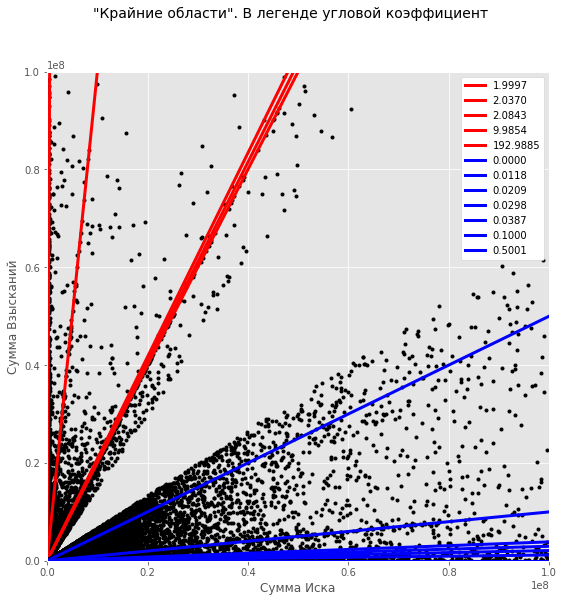

In [ ]:
pic_size=9
fig, ax = plt.subplots(ncols=1, figsize=(pic_size, pic_size))

after_parts = 100

cs, mrse, sz = calc_linapprox_on_size(quant_parts, visualise=0, df_ang=df_more_after)

df_after = (pd.DataFrame([cs, mrse, sz])).transpose()
df_after.columns = ['Points', 'MRSE', 'Size']
df_after.sort_values(by='Size', ascending=False, inplace=True)
df_after_best = df_after[:5].sort_values(by='Points')

draw_lin_approx(fig, ax, upper_bound=10**8,
                df=df_more_after, 
                coeffs=df_after_best['Points'].to_list(), 
                mrse=df_after_best['MRSE'].to_list(), 
                fmt='r', 
                leg='coef')


cs, mrse, sz = calc_linapprox_on_size(quant_parts, visualise=0, df_ang=df_more_before)
df_before = (pd.DataFrame([cs, mrse, sz])).transpose()
df_before.columns = ['Points', 'MRSE', 'Size']
df_before.sort_values(by='Size', ascending=False, inplace=True)

df_before_best = df_before[:7].sort_values(by='Points')

draw_lin_approx(fig, ax, upper_bound=10**8,
                df=df_more_before, 
                coeffs=df_before_best['Points'].to_list(), 
                mrse=df_before_best['MRSE'].to_list(), 
                fmt='b', 
                leg='coef')


fig.suptitle('"Крайние области". В легенде угловой коэффициент', fontsize=14);

Как можно заметить, легко наблюдаемые зрительно и не близкие к диагонали соотношения все были покрыты алгоритмом, поэтому метод можно рассматривать как возможное улучшение.

## **II. Уточненная функция потерь**

### **Обоснование необходимости и новая концепция**

Проблема использования средней квадратической ошибки в качестве функции потерь для текущей задачи проиллюстрирована на левой картинке ниже. Одинаково расположенные относительно границ угла точки и прямая (голубым цветом) внесут больший вклад в значение ошибки для первого угла с тангенсом наклона больше единицы, чем для второго.

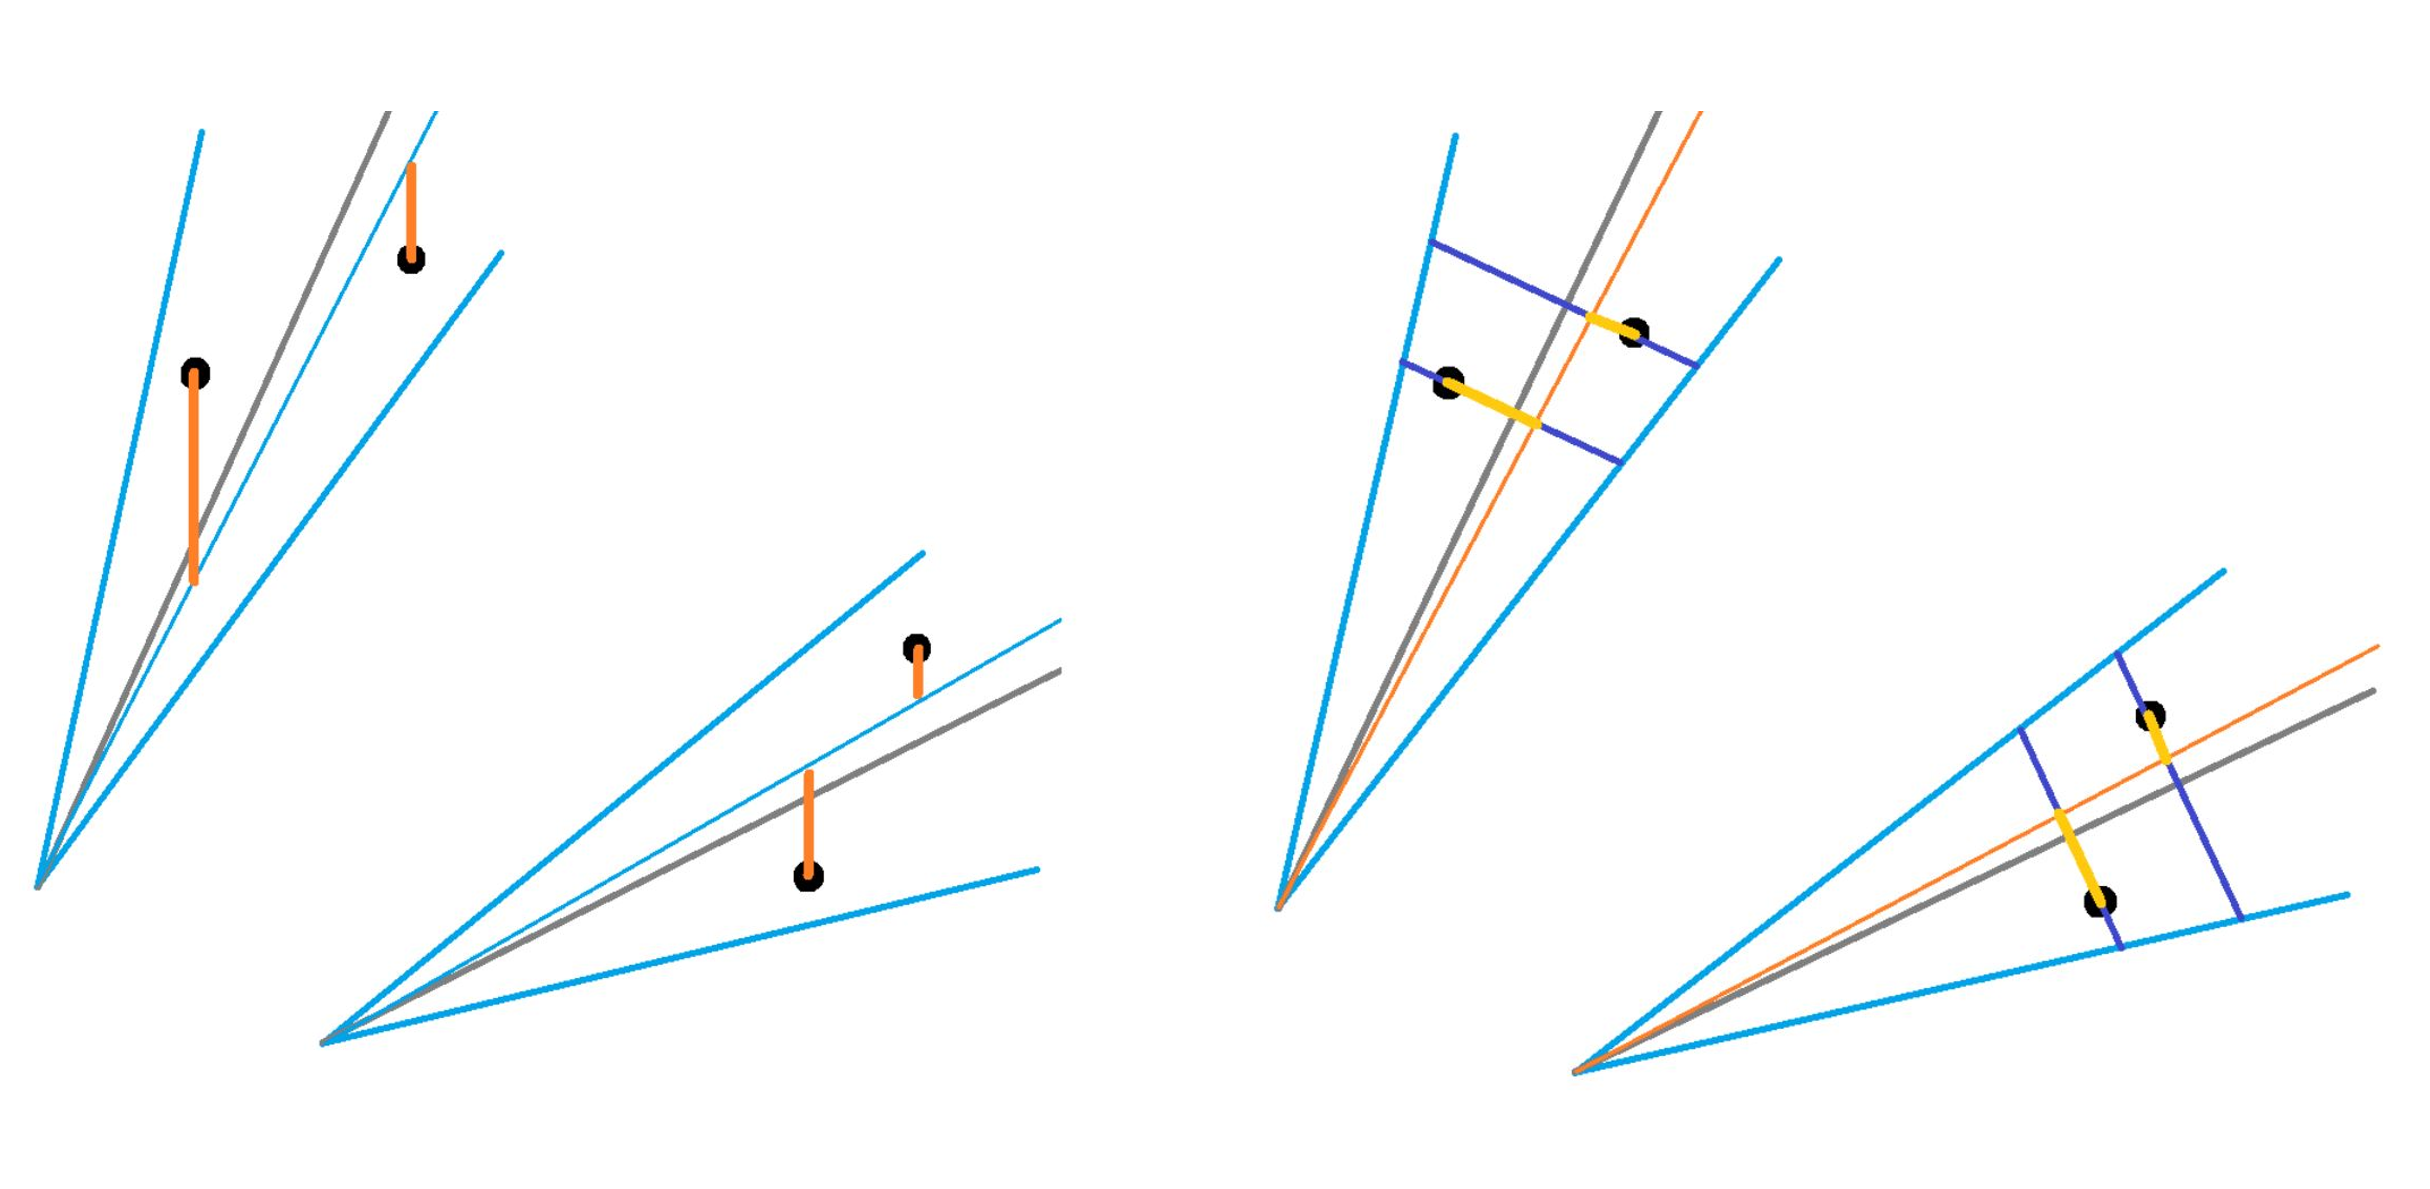

В качестве **альтернативной функции потерь** предлагается использовать как ориентир прямую, фиксированную относительно угла. Например, биссектрису угла. Можно измерять расстояние от точки до ожидаемого результата линейного приближения как длину перпендикулярного биссектрисе отрезка, соединяющего точку  (x_i1, y_i1) со своим пересечением приближения (x_i2, w * x_i2).

### **Функция ошибки, учитывающая угол наклона**

На вход подается множество пар координат точек из заданного угла, углы наклона к оси ординат ограничивающих его прямых. 

Наклон биссектрисы угла вычисляется как среднее арифметическое наклонов границ, его тангенс $k$. Тогда коэффициент $l$ для перпендикуляра к биссектрисе, опущенного из точки-дела $(x_0, y_0)$, в произведении с $l$ дает (-1). Далее нужно найти точку пересечения:

$$\begin{cases} 
y = (-1/k)x + (y_0 + (1/k)x_0) \\
y = kx
\end{cases} \\
kx = (-1/k)x + (y_0 + (1/k)x_0) \\
\Rightarrow \\
x* = \dfrac{ky_0 + x_0}{k^2 + 1}, y* = kx* = k\dfrac{ky_0 + x_0}{k^2 + 1}$$

Искомая величина - относительная ошибка, поэтому будет рассчитываться как расстояние от $(x_0, y_0)$ до $(x1, y1)$, нормированное на длину вектора $(x*, y*)$, где $(x1, y1)$ - это точка пересечения прямой линейного приближения множества точек с перпендикуляром. По аналогии с первыми рассчетами получаем:

$$x1 = \dfrac{ky_0 + x_0}{kw + 1}, y1 = wx1 = w\dfrac{ky_0 + x_0}{kw + 1}$$

In [ ]:
def dist(k, w, x0, y0) :
    x1 = (k*y0 + x0) / (k*k + 1)
    y1 = k*x1
    x2 = (k*y0 + x0) / (k*w + 1)
    y2 = w*x2
    dist = np.sqrt( (x2 - x0)*(x2 - x0) + (y2 - y0)*(y2 - y0))
    norm = np.sqrt( x1*x1 + y1*y1 )
    return (dist / norm).sum()


def new_dist(w0, w1, data, left, right):
    mid = (left + right) / 2
    return np.sqrt( dist(tan(mid), w1, data['Сумма Иска'], data['Сумма Взысканий']) / data.shape[0])

In [ ]:
import scipy.optimize as opt

error_wrap = lambda w1: new_dist(0, w1, df_wn, 0, pi/2)
wmin = opt.minimize_scalar(error_wrap)
wmin

     fun: 0.28705512523895355
    nfev: 24
     nit: 20
 success: True
       x: 1.0

### **Реализация подхода Перпендикуляров**

In [ ]:
def newdist_linapprox_with_size(num_parts, df_ang=df_ang, visualise=True, pic_size=9) :
  coeffs = [0 for i in range(num_parts)]
  mrse = [0 for i in range(num_parts)]
  dots = [0 for i in range(num_parts)]

  step = 1 / num_parts * (pi / 2)
  for k in range(num_parts) :
    left = k * step
    right = (k + 1) * step
    df_curr = df_ang[ (df_ang.sin >= sin(left)) & (df_ang.sin < sin(right))]
    dots[k] = df_curr.shape[0]
    if dots[k] == 0:
        mrse[k] = 100
    else: 
        error_wrap = lambda w1: new_dist(0, w1, df_curr, left, right)
        wmin = opt.minimize_scalar(error_wrap)
        # wmin.x - тангенс искомого угла, точки на единичной окружности
        coeffs[k] = atan(wmin.x)
        mrse[k] = wmin.fun

  if (visualise) :
      fig, ax = plt.subplots(ncols=1, figsize=(pic_size, pic_size))
      draw_lin_approx(fig, ax, 10**8, df_wn, coeffs, mrse)

  return coeffs, mrse, dots

In [ ]:
quant_parts = 181
cs, mrse, siz = newdist_linapprox_with_size(quant_parts, visualise=0)

df_upd = pd.DataFrame(cs, columns=['Points'])
df_upd['MRSE'] = mrse
df_upd['Size'] = siz
df_upd['Angle Num'] = df_upd.index
df_upd.sort_values(by='MRSE', inplace=True)

df_upd_best = df_upd[:10].sort_values(by='Points')

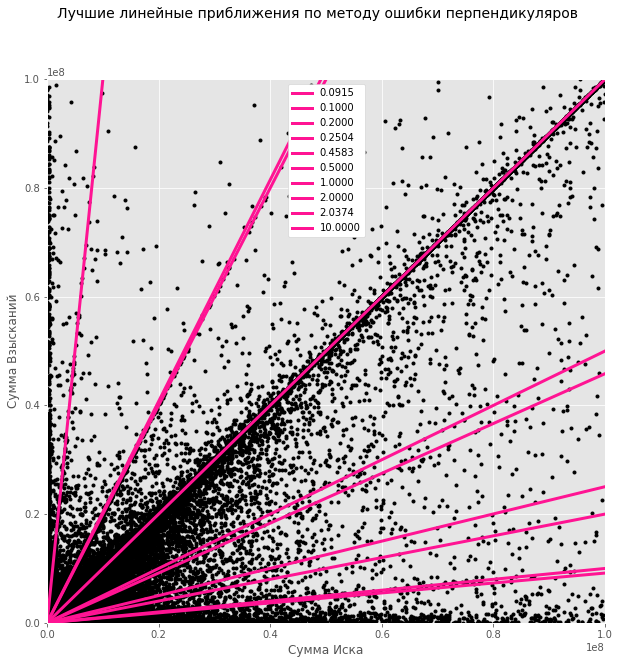

In [ ]:
pic_size=10
fig, ax = plt.subplots(ncols=1, figsize=(pic_size, pic_size))
draw_lin_approx(fig, ax, upper_bound=10**8, df=df_wn, 
                coeffs=df_upd_best['Points'].to_list(), 
                mrse=df_upd_best['MRSE'].to_list(),
                leg='coef', fmt='deeppink')
fig.suptitle('Лучшие линейные приближения по методу ошибки перпендикуляров', fontsize=14);

### Добавление сортировки по размеру выборки

In [ ]:
df_minnew = ((df_upd.sort_values(by='Size', ascending=False )[:60]).sort_values(by='MRSE')[:10]).sort_values(by='Points')

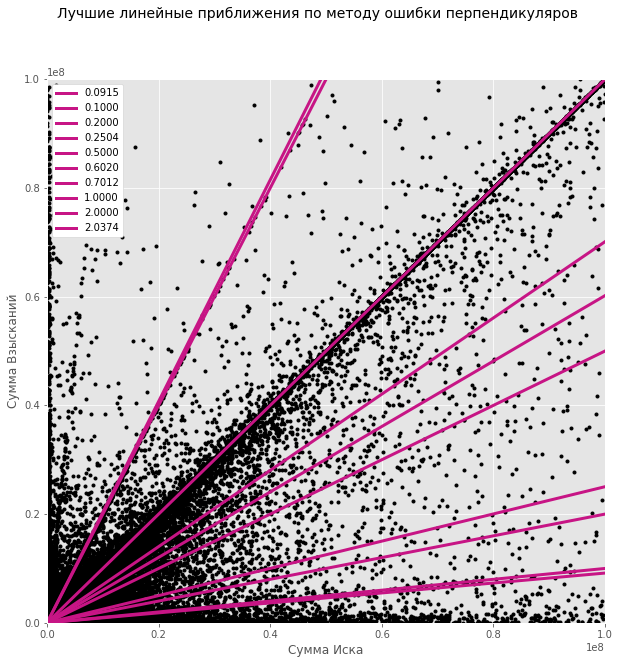

In [ ]:
pic_size=10
fig, ax = plt.subplots(ncols=1, figsize=(pic_size, pic_size))
draw_lin_approx(fig, ax, upper_bound=10**8, df=df_wn, 
                coeffs=df_minnew['Points'].to_list(), 
                mrse=df_minnew['MRSE'].to_list(),
                leg='coef', fmt='mediumvioletred')
fig.suptitle('Лучшие линейные приближения по методу ошибки перпендикуляров', fontsize=14);

## Для подмножества дел, разделяющих одну категорию

In [ ]:
path = '/content/drive/MyDrive/НУЛ АДП Материалы Марии Тимониной/_data/ArbitrageCleanedforSums.csv'
df = pd.read_csv(path, sep=',')

In [ ]:
d1 = df[(df['Категория Спора'] == 'Аренда транспортных средств - Заключение договора') |
        (df['Категория Спора'] == 'Аренда транспортных средств - Недействительность договора') |
        (df['Категория Спора'] == 'Аренда транспортных средств - Неисполнение или ненадлежащее исполнение обязательств')]

d2 = df[(df['Категория Спора'] == 'Лизинг - Заключение договора') |
        (df['Категория Спора'] == 'Лизинг - Недействительность договора') |
        (df['Категория Спора'] == 'О неисполнении или ненадлежащем исполнении обязательств по договорам финансовой аренды (лизинга)')]

d3 = df[(df['Категория Спора'] == 'Купля-продажа недвижимости - Заключение договора') |
        (df['Категория Спора'] == 'Купля-продажа недвижимости - Недействительность договора') |
        (df['Категория Спора'] == 'Купля-продажа недвижимости - Неисполнение или ненадлежащее исполнение обязательств') |
        (df['Категория Спора'] == 'Купля-продажа предприятия - Заключение договора') |
        (df['Категория Спора'] == 'Купля-продажа предприятия - Недействительность договора') |
        (df['Категория Спора'] == 'Купля-продажа предприятия - Неисполнение или ненадлежащее исполнение обязательств') |
        (df['Категория Спора'] == 'О неисполнении или ненадлежащем исполнении обязательств по договорам купли-продажи недвижимости и предприятий')]

d4 = df[(df['Категория Спора'] == 'О признании права собственности') |
        (df['Категория Спора'] == 'О признании права собственности на землю') |
        (df['Категория Спора'] == 'Споры, связанные с защитой права собственности')]

d5 = df[(df['Категория Спора'] == 'О защите авторских и смежных прав') |
        (df['Категория Спора'] == 'Связанные с защитой объектов авторского права') |
        (df['Категория Спора'] == 'о предоставлении или прекращении правовой охраны рез-ов интеллект. деятельности и средств индивидуализации (за искл. объек-ов автор-их и смеж. прав, топологий интегр. микросхем)') |
        (df['Категория Спора'] == 'о защите авторских прав')]

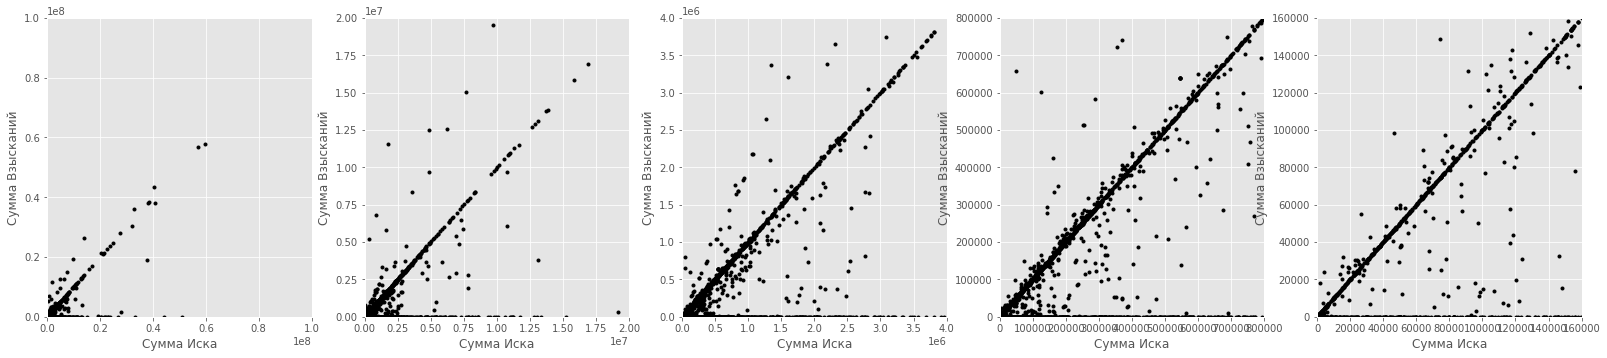

In [ ]:
d1 = df[(df['Категория Спора'] == 'Аренда транспортных средств - Заключение договора') |
        (df['Категория Спора'] == 'Аренда транспортных средств - Недействительность договора') |
        (df['Категория Спора'] == 'Аренда транспортных средств - Неисполнение или ненадлежащее исполнение обязательств')]

pic_size=5.5
dim = 5
fig, axs = plt.subplots(1, dim, figsize=(dim * pic_size, pic_size))
for n in range(dim) :
    upper_bound = 10**(8) / (5**n)
    plot_props_sums(axs[n], upper_bound, d1)

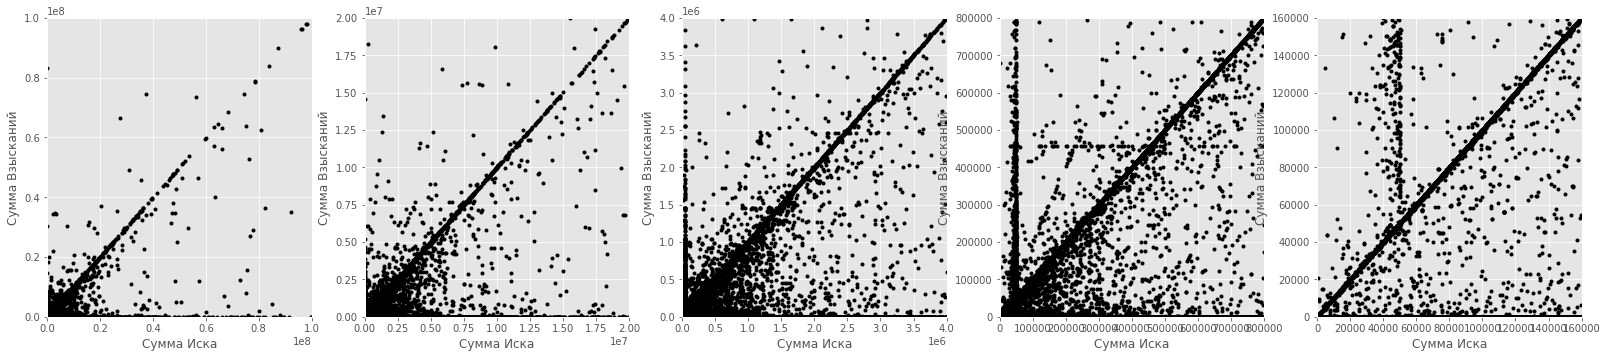

In [ ]:
d2 = df[(df['Категория Спора'] == 'Лизинг - Заключение договора') |
        (df['Категория Спора'] == 'Лизинг - Недействительность договора') |
        (df['Категория Спора'] == 'О неисполнении или ненадлежащем исполнении обязательств по договорам финансовой аренды (лизинга)')]

pic_size=5.5
dim = 5
fig, axs = plt.subplots(1, dim, figsize=(dim * pic_size, pic_size))
for n in range(dim) :
    upper_bound = 10**(8) / (5**n)
    plot_props_sums(axs[n], upper_bound, d2)

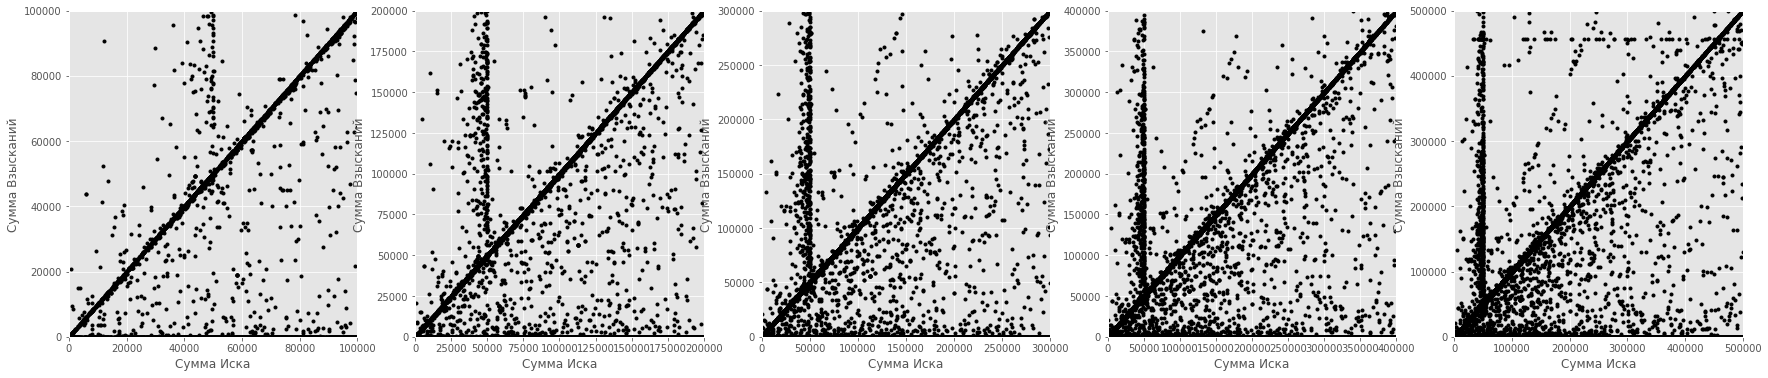

In [ ]:
pic_size=6
dim = 5
fig, axs = plt.subplots(1, dim, figsize=(dim * pic_size, pic_size))
for n in range(dim) :
    upper_bound = (10**(5)) * (n + 1)
    plot_props_sums(axs[n], upper_bound, d2)

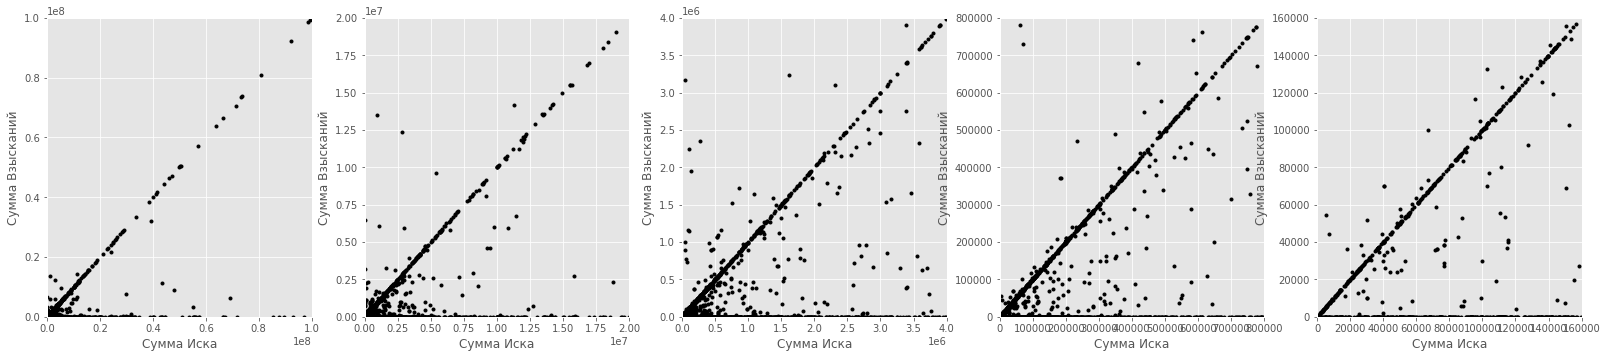

In [ ]:
d3 = df[(df['Категория Спора'] == 'Купля-продажа недвижимости - Заключение договора') |
        (df['Категория Спора'] == 'Купля-продажа недвижимости - Недействительность договора') |
        (df['Категория Спора'] == 'Купля-продажа недвижимости - Неисполнение или ненадлежащее исполнение обязательств') |
        (df['Категория Спора'] == 'Купля-продажа предприятия - Заключение договора') |
        (df['Категория Спора'] == 'Купля-продажа предприятия - Недействительность договора') |
        (df['Категория Спора'] == 'Купля-продажа предприятия - Неисполнение или ненадлежащее исполнение обязательств') |
        (df['Категория Спора'] == 'О неисполнении или ненадлежащем исполнении обязательств по договорам купли-продажи недвижимости и предприятий')]

pic_size=5.5
dim = 5
fig, axs = plt.subplots(1, dim, figsize=(dim * pic_size, pic_size))
for n in range(dim) :
    upper_bound = 10**(8) / (5**n)
    plot_props_sums(axs[n], upper_bound, d3)

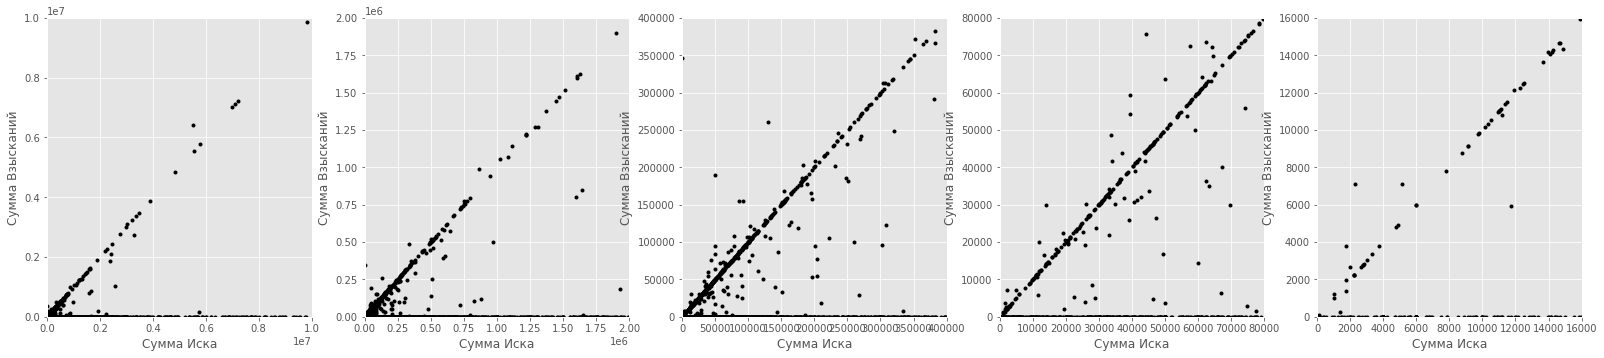

In [ ]:
d4 = df[(df['Категория Спора'] == 'О признании права собственности') |
        (df['Категория Спора'] == 'О признании права собственности на землю') |
        (df['Категория Спора'] == 'Споры, связанные с защитой права собственности')]

pic_size=5.5
dim = 5
fig, axs = plt.subplots(1, dim, figsize=(dim * pic_size, pic_size))
for n in range(dim) :
    upper_bound = 10**(7) / (5**n)
    plot_props_sums(axs[n], upper_bound, d4)

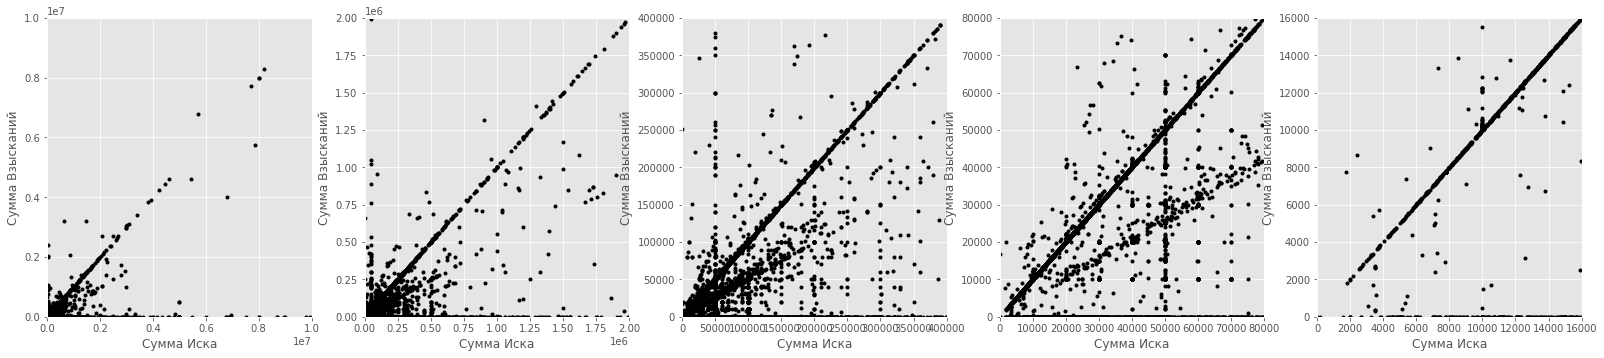

In [ ]:
d5 = df[(df['Категория Спора'] == 'О защите авторских и смежных прав') |
        (df['Категория Спора'] == 'Связанные с защитой объектов авторского права') |
        (df['Категория Спора'] == 'о предоставлении или прекращении правовой охраны рез-ов интеллект. деятельности и средств индивидуализации (за искл. объек-ов автор-их и смеж. прав, топологий интегр. микросхем)') |
        (df['Категория Спора'] == 'о защите авторских прав')]

pic_size=5.5
dim = 5
fig, axs = plt.subplots(1, dim, figsize=(dim * pic_size, pic_size))
for n in range(dim) :
    upper_bound = 10**(7) / (5**n)
    plot_props_sums(axs[n], upper_bound, d5)

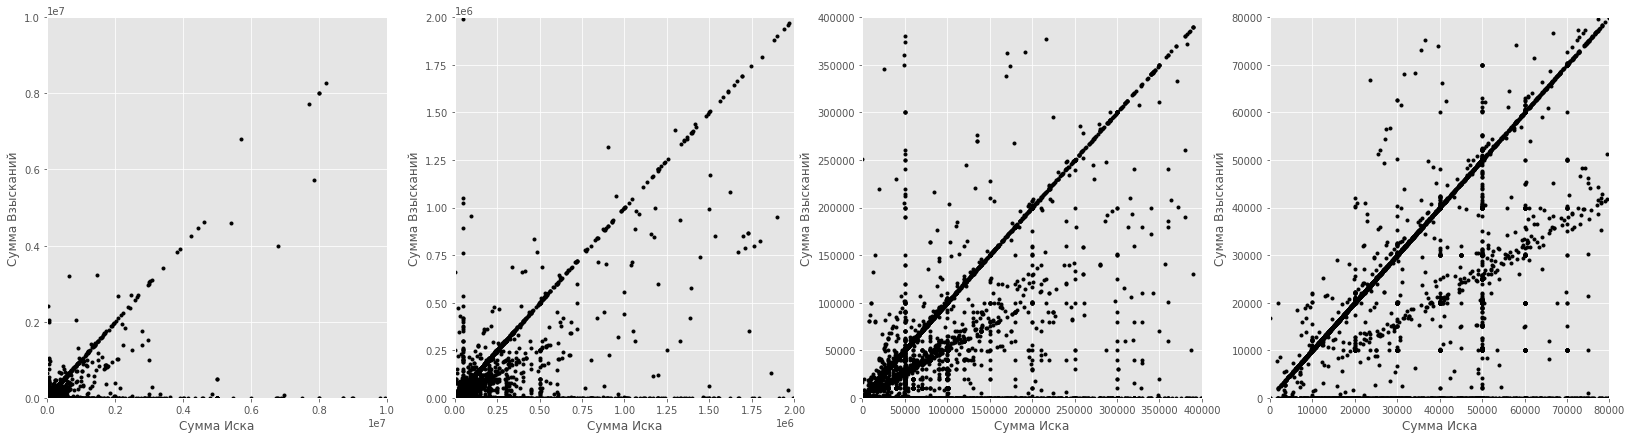

In [ ]:
pic_size=7
dim = 4
fig, axs = plt.subplots(1, dim, figsize=(dim * pic_size, pic_size))
for n in range(dim) :
    upper_bound = 10**(7) / (5**n)
    plot_props_sums(axs[n], upper_bound, d5)

# Возможные новые вопросы исследования

* Можно для каждой категории с достаточным количеством дел найти самое часто встречающееся соотношения Сумм Иска и Взысканий в рамках нее - вдруг будет заметна закономерность.

* Выделить углы, близкие к осям абсцисс и ординат (околонулевая одна из сумм), и рассматривать их по другим критериям(?)

* Если производится попытка выделить соотношения, устойчивые и потенциально закрепленные в нормативных актах, можно провести сравнение между углами, заданными коэффициентом вида $n$ и $1/n$, где $n$ - натуральное число, в границах допустимых смысловой нагрузкой значений. Например, от 1 до 100.

---

#**Распределение по категориям в окрестности устойчивого соотношения**


Выберем дела в окрестности соотношения Сумма Взыскания : Сумма Иска, равного 2. Окрестность радиуса 0.1.

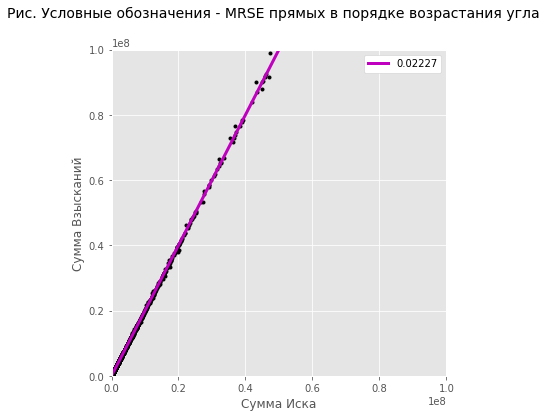

In [ ]:
pic_size=6
df_dva = df_wn[((df_wn['Сумма Взысканий'] > (2 - 0.1) * df_wn['Сумма Иска'])) &
               ((df_wn['Сумма Взысканий'] < (2 + 0.1) * df_wn['Сумма Иска']))]
fig, ax = plt.subplots(ncols=1, figsize=(pic_size, pic_size))
draw_lin_approx(fig, ax, upper_bound=10**8, df=df_dva,
                coeffs=[df_upd_best['Points'].to_list()[7]], 
                mrse=[df_upd_best['MRSE'].to_list()[7]],
                leg='std_mrse')
fig.suptitle('Рис. Условные обозначения - MRSE прямых в порядке возрастания угла', fontsize=14);

График выше показывает, что дела отобраны именно те, к которым мы хотим присмотреться.

In [ ]:
df_dva.shape[0]

14244

In [ ]:
df_dva['Категория Спора'].value_counts()[:10].values

array([3074, 2152, 1168, 1031,  975,  958,  659,  505,  457,  293])

In [ ]:
df_dva['Категория Спора'].value_counts()[:10]

О неисполнении или ненадлежащем исполнении обязательств по договорам поставки                                                       3074
Энергоснабжение - Неисполнение или ненадлежащее исполнение обязательств                                                             2152
Услуги - Неисполнение или ненадлежащее исполнение обязательств                                                                      1168
О неисполнении или ненадлежащем исполнении обязательств по договорам страхования                                                    1031
О взыскании в Пенсионный фонд обязат. платежей и санкций с организаций и граждан, если не предусмотрен иной порядок их взыскания     975
О неисполнении или ненадлежащем исполнении обязательств по договорам подряда                                                         958
Взыскание обязательных платежей и санкций в Фонд социального страхования                                                             659
О неисполнении или ненадлежащем исполнени

Бывают разные виды спора (без учета предмета договора - не смотрим сейчас страхование это или энергосбережение или что-то еще). А главный вид спора в этом соотношении: Неисполнение или ненадлежащее исполнении обязательств

Можно выделить доминирующие регионы:

In [ ]:
df_dva['Суд'].value_counts()[:20]

АС Республики Татарстан                            2393
АС Курганской области                              1491
АС Саратовской области                              908
АС Красноярского края                               818
АС Оренбургской области                             634
АС Приморского края                                 611
АС Тверской области                                 610
АС города Санкт-Петербурга и Ленинградской обл.     585
АС Хабаровского края                                551
АС Новгородской области                             477
АС Самарской области                                465
АС Курской области                                  408
АС города Москвы                                    316
АС Астраханской области                             290
АС Нижегородской области                            277
АС Ярославской области                              276
АС Тюменской области                                184
АС Чувашской Республики                         

А как распределены категории у региона-лидера?

In [ ]:
df_dva[df_dva['Суд'] == 'АС Республики Татарстан']['Категория Спора'].value_counts()[:10]

О неисполнении или ненадлежащем исполнении обязательств по договорам поставки                         1134
Энергоснабжение - Неисполнение или ненадлежащее исполнение обязательств                                213
О неисполнении или ненадлежащем исполнении обязательств по договорам страхования                       189
Услуги - Неисполнение или ненадлежащее исполнение обязательств                                         185
Переход к страховщику прав страхователя на возмещение ущерба (суброгация) - иные споры гражданские     138
О неисполнении или ненадлежащем исполнении обязательств по договорам подряда                           108
О неисполнении или ненадлежащем исполнении обязательств по договорам аренды                             95
О неисполнении или ненадлежащем исполнении обязательств по договорам строительного подряда              55
О неисполнении или ненадлежащем исполнении обязательств по договорам перевозки                          37
Неосновательное обогащение           

Посмотрим, что происходит с другими устойчивыми соотношениями:

---
---
---

**Соотношение 10 : 1**

In [ ]:
df_ten = df_wn[((df_wn['Сумма Взысканий'] > (10 - 0.2) * df_wn['Сумма Иска'])) &
               ((df_wn['Сумма Взысканий'] < (10 + 0.2) * df_wn['Сумма Иска']))]

print(df_ten.shape[0], 'дел из', df_wn.shape[0], ':   это соcтавит', df_ten.shape[0] / df_wn.shape[0])

1352 дел из 1777537 :   это соcтавит 0.0007606030141707317


In [ ]:
df_ten['Категория Спора'].value_counts()[:20].values

array([221, 193, 150, 124,  91,  81,  68,  42,  37,  37,  33,  31,  25,
        24,  18,  16,  12,   9,   9,   8])

In [ ]:
df_ten['Категория Спора'].value_counts()[:10]

О неисполнении или ненадлежащем исполнении обязательств по договорам поставки                       221
О неисполнении или ненадлежащем исполнении обязательств по договорам страхования                    193
Энергоснабжение - Неисполнение или ненадлежащее исполнение обязательств                             150
О неисполнении или ненадлежащем исполнении обязательств по договорам энергоснабжения                124
О неисполнении или ненадлежащем исполнении обязательств по договорам подряда                         91
О неисполнении или ненадлежащем исполнении обязательств по договорам возмездного оказания услуг      81
О неисполнении или ненадлежащем исполнении обязательств по договорам аренды                          68
О неисполнении или ненадлежащем исполнении обязательств по договорам строительного подряда           42
Услуги - Неисполнение или ненадлежащее исполнение обязательств                                       37
О неисполнении или ненадлежащем исполнении обязательств по догов

Снова видим "О неисполнении или ненадлежащем исполнении обязательств"!

In [ ]:
df_ten['Суд'].value_counts()[:10]

АС города Москвы                                   407
АС города Санкт-Петербурга и Ленинградской обл.    171
АС Московской области                               75
АС Свердловской области                             59
АС Волгоградской области                            53
АС Республики Башкортостан                          33
АС Ростовской области                               24
АС Краснодарского края                              22
АС Новосибирской области                            22
АС Пензенской области                               21
Name: Суд, dtype: int64

***
***
***

**Соотношение 1 : 10**

In [ ]:
df_one_tenth = df_wn[((df_wn['Сумма Взысканий'] > (1/10 - 0.01) * df_wn['Сумма Иска'])) &
               ((df_wn['Сумма Взысканий'] < (1/10 + 0.01) * df_wn['Сумма Иска']))]

print(df_one_tenth.shape[0], 'дел из', df_wn.shape[0], ':   это соcтавит', df_one_tenth.shape[0] / df_wn.shape[0])

8277 дел из 1777537 :   это соcтавит 0.004656443157020079


In [ ]:
df_one_tenth['Категория Спора'].value_counts()[:20].values

array([1353,  874,  725,  630,  624,  462,  370,  359,  332,  308,  258,
        129,  125,  125,   95,   95,   90,   76,   70,   66])

In [ ]:
df_one_tenth['Категория Спора'].value_counts()[:10]

О неисполнении или ненадлежащем исполнении обязательств по договорам поставки                                                       1353
О взыскании в Пенсионный фонд обязат. платежей и санкций с организаций и граждан, если не предусмотрен иной порядок их взыскания     874
О неисполнении или ненадлежащем исполнении обязательств по договорам страхования                                                     725
О неисполнении или ненадлежащем исполнении обязательств по договорам энергоснабжения                                                 630
О неисполнении или ненадлежащем исполнении обязательств по договорам подряда                                                         624
О неисполнении или ненадлежащем исполнении обязательств по договорам возмездного оказания услуг                                      462
Энергоснабжение - Неисполнение или ненадлежащее исполнение обязательств                                                              370
О неисполнении или ненадлежащем исполнени

In [ ]:
df_one_tenth['Суд'].value_counts()[:10]

АС города Москвы                                   1357
АС города Санкт-Петербурга и Ленинградской обл.     417
АС Свердловской области                             415
АС Московской области                               373
АС Саратовской области                              327
АС Волгоградской области                            282
АС Ростовской области                               212
АС Краснодарского края                              172
АС Приморского края                                 154
АС Челябинской области                              146
Name: Суд, dtype: int64

In [ ]:
df_one_tenth[df_one_tenth['Суд'] == 'АС города Москвы']['Категория Спора'].value_counts()[:10]

О неисполнении или ненадлежащем исполнении обязательств по договорам страхования                          303
О неисполнении или ненадлежащем исполнении обязательств по договорам поставки                             288
О неисполнении или ненадлежащем исполнении обязательств по договорам возмездного оказания услуг           142
О неисполнении или ненадлежащем исполнении обязательств по договорам строительного подряда                106
О неисполнении или ненадлежащем исполнении обязательств по договорам энергоснабжения                       68
О неисполнении или ненадлежащем исполнении обязательств по договорам подряда                               62
О неисполнении или ненадлежащем исполнении обязательств по договорам аренды                                56
О неисполнении или ненадлежащем исполнении обязательств по договорам финансовой аренды (лизинга)           51
О неисполнении или ненадлежащем исполнении обязательств по договорам перевозки                             51
О неисполн

# **Одномерный График Соотношений**

In [ ]:
df_otn = df_wn[['Сумма Иска', 'Сумма Взысканий']]
df_otn['Взыск/Иск'] = df_otn['Сумма Взысканий'] / df_otn['Сумма Иска']
df_otn

,Сумма Иска,Сумма Взысканий,Взыск/Иск
0,34484.90,36484.90,1.057996
1,132000.00,176979.00,1.340750
3,4612.55,4612.55,1.000000
4,17745.20,2000.00,0.112707
6,107657.00,107657.00,1.000000
...,...,...,...
2729216,43596.10,48596.10,1.114689
2729217,72300.00,72300.00,1.000000
2729218,49879.00,54879.00,1.100243
2729220,124471.00,124471.00,1.000000


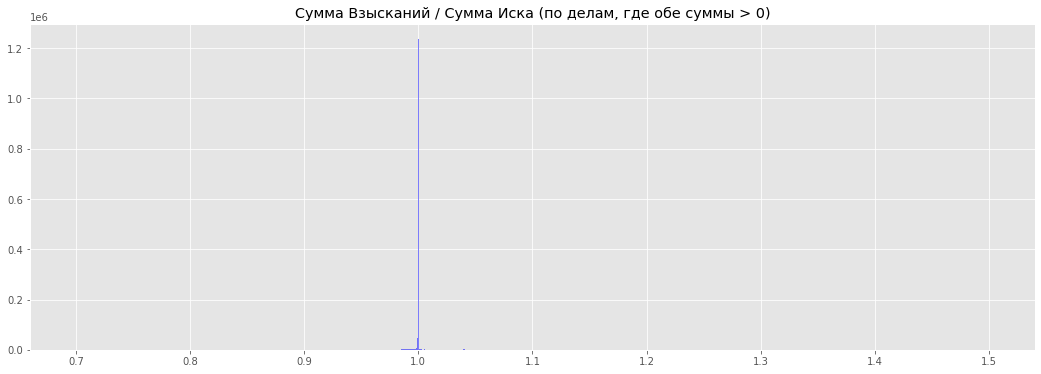

In [ ]:
fig, ax = plt.subplots(ncols=1, figsize=(18, 6))

test = df_otn[(df_otn['Взыск/Иск'] < 1.5) & (df_otn['Взыск/Иск'] > 0.7)]['Взыск/Иск']

ax.hist(test, bins=1000, color="b", alpha=0.5, );
ax.set_title("Сумма Взысканий / Сумма Иска (по делам, где обе суммы > 0)");